In [1]:
using DataFrames, CSV, Plots, Statistics, DataStructures, JLD, Plots.PlotMeasures, LaTeXStrings, DynamicalSystems, Distributions, Random, StatsBase, KernelDensity, Interpolations, StatsPlots

path_to_files = "/home/matt/Desktop/Advanced_Analytics/Dissertation/Code/MDTG-MALABM/"
include(path_to_files * "Scripts/Moments.jl"); 

## Read rl results data

In [2]:
b0_s1 = load("../Data/RL/Training/MARL/Results_Buy_0_Sell_1_alpha0.1_lambda0.003_gamma0.25.jld")["rl_results"]
b1_s0 = load("../Data/RL/Training/MARL/Results_Buy_1_Sell_0_alpha0.1_lambda0.003_gamma0.25.jld")["rl_results"]
b1_s1 = load("../Data/RL/Training/MARL/Results_Buy_1_Sell_1_alpha0.1_lambda0.003_gamma0.25.jld")["rl_results"]

Dict{Int64, Dict} with 1000 entries:
  719 => Dict{Any, Any}("rlAgent_1"=>Dict{String, Any}("Q"=>Dict([4, 3, 5, 4]=>…
  858 => Dict{Any, Any}("rlAgent_1"=>Dict{String, Any}("Q"=>Dict([4, 3, 5, 4]=>…
  699 => Dict{Any, Any}("rlAgent_1"=>Dict{String, Any}("Q"=>Dict([4, 3, 5, 4]=>…
  831 => Dict{Any, Any}("rlAgent_1"=>Dict{String, Any}("Q"=>Dict([4, 3, 5, 4]=>…
  983 => Dict{Any, Any}("rlAgent_1"=>Dict{String, Any}("Q"=>Dict([4, 3, 5, 4]=>…
  673 => Dict{Any, Any}("rlAgent_1"=>Dict{String, Any}("Q"=>Dict([4, 3, 5, 4]=>…
  319 => Dict{Any, Any}("rlAgent_1"=>Dict{String, Any}("Q"=>Dict([4, 3, 5, 4]=>…
  73  => Dict{Any, Any}("rlAgent_1"=>Dict{String, Any}("Q"=>Dict([2, 1, 1, 4]=>…
  251 => Dict{Any, Any}("rlAgent_1"=>Dict{String, Any}("Q"=>Dict([4, 3, 5, 4]=>…
  687 => Dict{Any, Any}("rlAgent_1"=>Dict{String, Any}("Q"=>Dict([4, 3, 5, 4]=>…
  115 => Dict{Any, Any}("rlAgent_1"=>Dict{String, Any}("Q"=>Dict([2, 1, 1, 4]=>…
  112 => Dict{Any, Any}("rlAgent_1"=>Dict{String, Any}("Q"=>Dict([2, 1, 

In [41]:
marl_data = Dict("b1_s0" => b1_s0, "b0_s1" => b0_s1, "b1_s1" => b1_s1)

Dict{String, Dict{Int64, Dict}} with 3 entries:
  "b1_s1" => Dict(719=>Dict{Any, Any}("rlAgent_1"=>Dict{String, Any}("Q"=>Dict(…
  "b1_s0" => Dict(719=>Dict{Any, Any}("rlAgent_1"=>Dict{String, Any}("Q"=>Dict(…
  "b0_s1" => Dict(719=>Dict{Any, Any}("rlAgent_1"=>Dict{String, Any}("Q"=>Dict(…

In [51]:
marl_data["b1_s1"][1]["rlAgent_1"]["ActionType"]

"Buy"

## Reward convergence

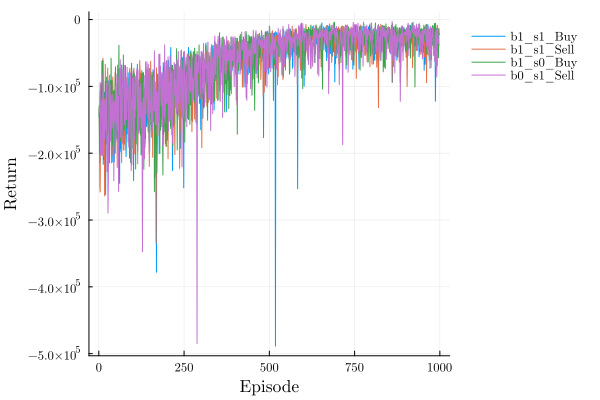

In [57]:
function RewardConvergence(marl_data)
    p = nothing
    for (j, key) in enumerate(keys(marl_data))
        res = marl_data[key]
        num_episodes = length(res)
        for (k, agent) in enumerate(keys(res[1]))
            if j == 1 && k == 1
                p = plot([res[i][agent]["TotalReward"] for i in 1:num_episodes if abs(res[i][agent]["TotalReward"]) < 5e5], legend = :outertopright, xlabel = "Episode", ylabel = "Return", label = key * "_" * res[k][agent]["ActionType"], titlefontsize = 6, legendfontsize = 8, fg_legend = :transparent, fontfamily="Computer Modern")
            else
                plot!([res[i][agent]["TotalReward"] for i in 1:num_episodes if abs(res[i][agent]["TotalReward"]) < 5e5], legend = :outertopright, xlabel = "Episode", ylabel = "Return", label = key * "_" * res[k][agent]["ActionType"], titlefontsize = 6, legendfontsize = 8, fg_legend = :transparent, fontfamily="Computer Modern")    
            end
        end
    end
    return p
end
RewardConvergence(marl_data)


## Model distance function

In [ ]:
function MDF(rlAgentMoments, calibratedMoments)
    calibratedMoments_list = [calibratedMoments.μ, calibratedMoments.σ, calibratedMoments.ks, calibratedMoments.hurst, calibratedMoments.gph, calibratedMoments.adf, calibratedMoments.garch, calibratedMoments.hill]
    rlAgentMoments_list = [rlAgentMoments.μ, rlAgentMoments.σ, rlAgentMoments.ks, rlAgentMoments.hurst, rlAgentMoments.gph, rlAgentMoments.adf, rlAgentMoments.garch, rlAgentMoments.hill]
    return sum((rlAgentMoments_list .- calibratedMoments_list).^2)
end


## State space recon